# <center> Tarea semanal 6</center>
### <center> Autores: Arturo Huber, Matias Galperin</center>

## Introducción Teórica

En este trabajo se utilizó un electrocardiograma (ECG), el cual es una señal bioeléctrica de muy baja amplitud (del orden de los milivoltios) generada por la actividad eléctrica del corazón. Debido a su bajo nivel y a que es registrada mediante electrodos de superficie, la señal es altamente susceptible a múltiples fuentes de ruido que distorsionan su morfología y dificultan su análisis clínico.

Para recuperar la información relevante del ECG es necesario aplicar técnicas de procesamiento digital de señales (DSP) que permitan atenuar las contaminaciones externas sin alterar la estructura fisiológica de los complejos cardíacos (ondas P, QRS y T). En este trabajo se diseñan y comparan distintos filtros digitales FIR e IIR para limpiar un registro real de ECG durante una prueba de esfuerzo.

### Fuentes de ruido en el ECG

Las principales interferencias presentes en un registro típico son:

1. Deriva de la línea de base (Baseline Wander)

Provocada por la respiración, el movimiento torácico, cambios en el contacto de los electrodos y desplazamientos del paciente.
Aparece principalmente en frecuencias muy bajas: $𝑓≲0.5Hz$

Efecto: desplazamiento lento del nivel isoeléctrico.

2. Ruido muscular (EMG)

Generado por la actividad eléctrica de los músculos esqueléticos. Su espectro es amplio y dominante en: $𝑓≳60Hz$

Efecto: componente de alta frecuencia que sobreimpone irregularidades y “rugosidad” al ECG.

3. Ruido por movimiento de electrodos

Se produce cuando el electrodo cambia su impedancia debido al movimiento de la piel.
Genera tanto ruido de baja como de alta frecuencia, pero particularmente aparece como picos y oscilaciones rápidas.

### Banda útil del ECG

La mayor parte de la energía fisiológica del ECG se concentra aproximadamente en el rango: $0.5Hz ≤ 𝑓 ≤ 40Hz$

La onda P ocupa bajas frecuencias (≈ 1–15 Hz).

El complejo QRS contiene energía hasta ≈ 40 Hz.

La onda T se encuentra entre ≈ 1–7 Hz.

Por lo tanto, un filtro adecuado debe preservar esta banda y atenuar el resto.

### Filtros digitales FIR e IIR

Para limpiar un ECG pueden emplearse filtros FIR (Finite Impulse Response), los cuales se diseñan mediante:

Ventanas (Hamming, Blackman, etc.).

Mínimos cuadrados.

Parks–McClellan (Remez).

También existen los filtros IIR (Infinite Impulse Response), que requieren menor orden para la misma selectividad, pero no garantizan fase lineal. Sus aproximaciones clásicas son:

Butterworth (módulo de máxima planicidad).

Chebyshev I (rizado en banda pasante).

Elíptico (Cauer) (más selectivo, rizado en pasante y rechazo).

### Objetivo general

Implementar, comparar y evaluar varios filtros digitales diseñados según la plantilla propuesta, con el fin de atenuar eficientemente las interferencias del ECG, preservar la estructura temporal y espectral de los latidos y analizar cuál metodología (FIR o IIR) ofrece mejor desempeño para el registro provisto.

## Análisis y Desarrollo

Se utilizó el archivo ECG_TP4.mat que contiene un registro de ECG muestreado a $𝑓𝑠=1000Hz$

A partir del análisis espectral del ECG realizado en la Tarea Semanal 5 y del conocimiento fisiológico de la señal, se establecó la siguiente banda útil: $0.5Hz≤𝑓≤40Hz$

Las interferencias a eliminar se concentran en baja frecuencia (baseline wander) $𝑓<0.5Hz$ y en alta frecuencia (ruido muscular, movimiento) $𝑓>60Hz$. Con estos valores se construyó la siguiente plantilla:

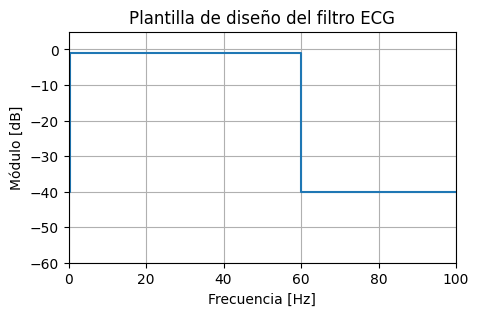

In [2]:
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write
from scipy.io import loadmat


#%% Punto a:
data = loadmat("ECG_TP4")
ecg_one_lead = data["ecg_lead"].flatten()
cant_muestras = len(ecg_one_lead)
    
fs = 1000
nyq_frec = fs/2
ripple = 1      # dB
atenuacion = 40 # dB

ws1 = 0.1  # rechazo muy cerca de DC
wp1 = 0.5  # empieza la banda útil
wp2 = 40   # fin de banda útil
ws2 = 60   # rechazo de ruido muscular / HF

# Normalizadas
ws1_n = ws1/nyq_frec
wp1_n = wp1/nyq_frec
wp2_n = wp2/nyq_frec
ws2_n = ws2/nyq_frec

frecs = np.array([0.0, ws1, wp1, wp2, ws2, nyq_frec]) / nyq_frec
gains_db = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains_db/20)

plt.figure(figsize=(5,3))
plt.step(frecs*nyq_frec, gains_db, where='post')
plt.ylim([-60, 5])
plt.xlim([0, 100])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.title('Plantilla de diseño del filtro ECG')
plt.grid(True)
plt.show()

### Diseño de filtros FIR e IIR

A continuación se diseñaron dos filtros FIR y dos filtros IIR utilizando scipy.signal.

FIR 1 — Ventana de Hamming

Implementado mediante:

In [3]:
numtaps = 801   # siempre impar para banda pasante simétrica

fir_win = signal.firwin(
    numtaps,
    [wp1_n, wp2_n],
    window='hamming',
    pass_zero=False
)

FIR 2 — Parks–McClellan (Remez)

Implementado mediante:

In [4]:
numtaps = 401

bands   = [0, 0.2,   0.7, 40,   60, nyq_frec*0.999]     # [0–0.2 Hz stop] [0.7–40 Hz pass] [60–500 Hz stop]
desired = [0,         1,         0]
weights = [1,         1,         1]

fir_remez = signal.remez(
    numtaps=numtaps,
    bands=bands,
    desired=desired,
    weight=weights,
    fs=fs
)

### Filtros IIR

Se implementó un filtro Butterworth (máxima planicidad en pasabanda) y un filtro Elíptico (Cauer), ambos de orden 4, para evitar órdenes excesivos o comportamiento no deseado.

IIR 1 — Butterworth

In [5]:
# Frecuencias normalizadas para IIR
wp1_n = wp1 / nyq_frec   # 0.5 / 500
wp2_n = wp2 / nyq_frec   # 40 / 500
band_n = [wp1_n, wp2_n]

N_butt = 4
b_butt, a_butt = signal.butter(
    N_butt,
    band_n,
    btype="bandpass"
)

IIR 2 — Elíptico (Cauer)

In [6]:
N_ellip = 4
b_ellip, a_ellip = signal.ellip(
    N_ellip,
    ripple,    # 1 dB en banda pasante
    atenuacion,     # 40 dB en stop
    band_n,
    btype="bandpass"
)

Se graficó la respuesta en frecuencia de todos los filtros junto con la plantilla. Los resultados muestran:

FIR ventana: respuesta suave, fase lineal, buen cumplimiento de la plantilla.

FIR Remez: el más cercano a la plantilla ideal en las transiciones.

IIR Butterworth: transición moderada, comportamiento suave.

IIR Elíptico: el más selectivo, con bordes de banda más abruptos.

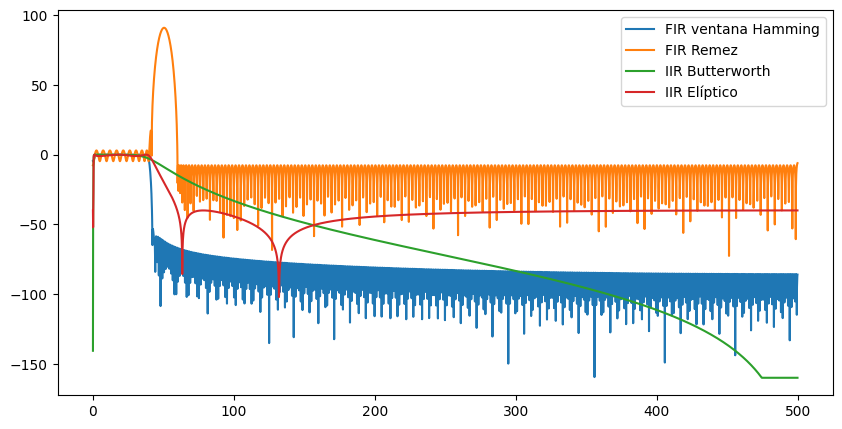

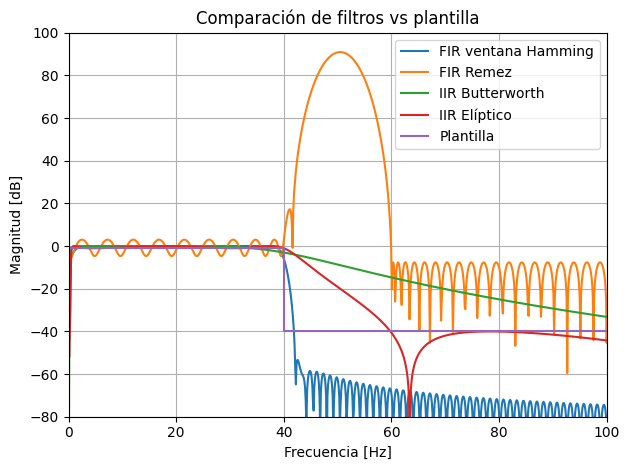

In [7]:
def plot_resp(b, a=1, label=""):
    w, h = signal.freqz(b, a, worN=4096, fs=fs)
    # Evitamos log10(0): acotamos a algo muy chico
    Hdb = 20*np.log10(np.maximum(np.abs(h), 1e-8))
    plt.plot(w, Hdb, label=label)
    plt.legend()

plt.figure(figsize=(10,5))

plot_resp(fir_win, label = "FIR ventana Hamming")
plot_resp(fir_remez, label = "FIR Remez")
plot_resp(b_butt, a_butt, label = "IIR Butterworth")
plot_resp(b_ellip, a_ellip, label = "IIR Elíptico")
plt.show()

# Plantilla superpuesta
plot_resp(fir_win, 1, label = "FIR ventana Hamming")
plot_resp(fir_remez, 1, label = "FIR Remez")
plot_resp(b_butt, a_butt, label = "IIR Butterworth")
plot_resp(b_ellip, a_ellip, label = "IIR Elíptico")
plt.step(frecs*nyq_frec, gains_db, label = "Plantilla")
plt.xlim([0, 100])
plt.ylim([-80, 100])
plt.grid(True)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.title("Comparación de filtros vs plantilla")
plt.legend()
plt.tight_layout()
plt.show()

### Aplicación de los filtros al ECG

Los filtros se aplicaron mediante filtfilt. Se evaluaron en regiones con ruido, analizando segmentos conocidos del registro donde existe ruido muscular, movimiento de electrodos, oscilaciones de alta frecuencia. En estas regiones el filtrado reduce notablemente las componentes de alta frecuencia, elimina oscilaciones rápidas, estabiliza el nivel isoeléctrico, preserva la forma general del QRS. Además, en zonas sin ruido el filtrado reduce notablemente las componentes de alta frecuencia, elimina oscilaciones rápidas, estabiliza el nivel isoeléctrico, preserva la forma general del QRS. 

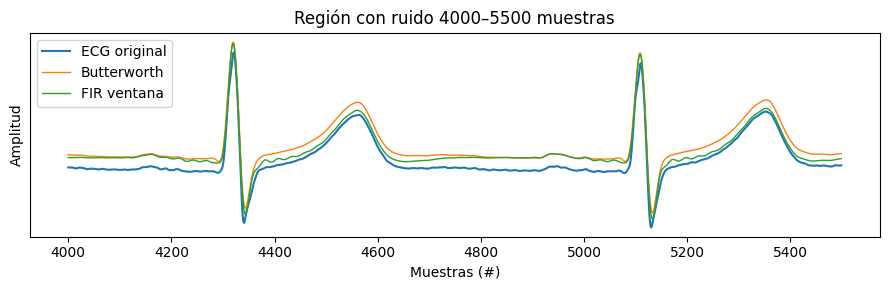

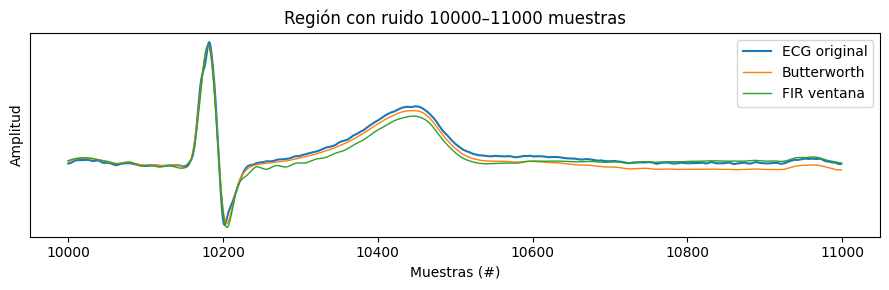

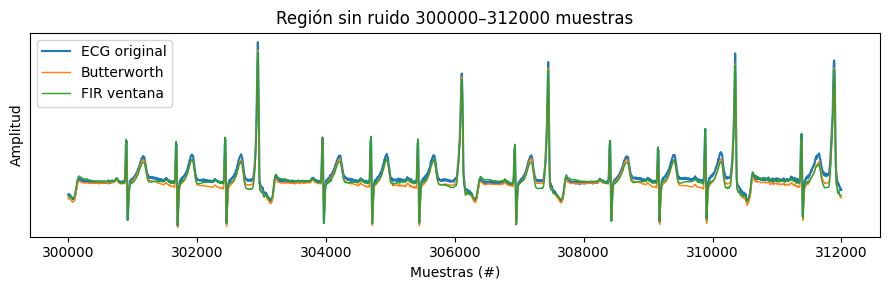

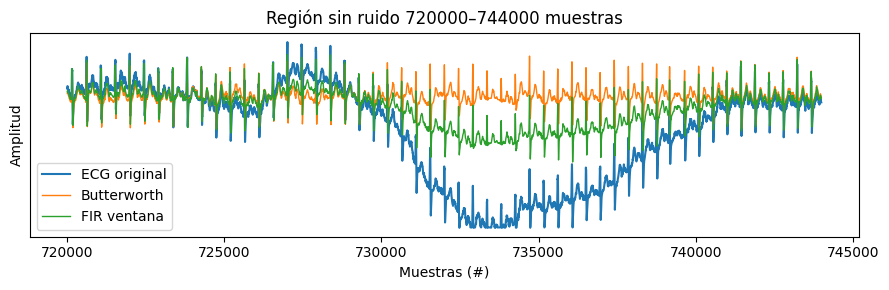

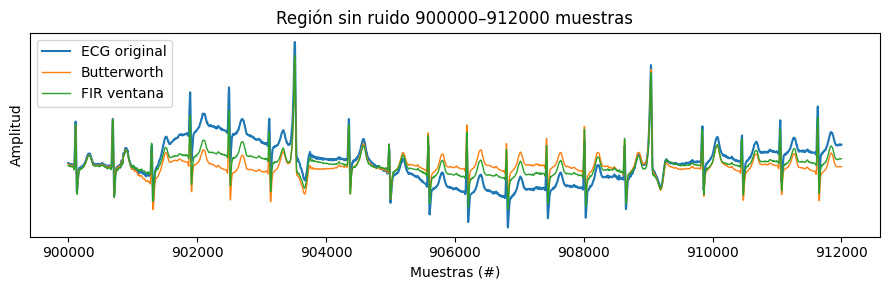

In [8]:
ECG_f_win   = signal.filtfilt(fir_win, 1, ecg_one_lead)
ECG_f_remez = signal.filtfilt(fir_remez, 1, ecg_one_lead)
ECG_f_butt  = signal.filtfilt(b_butt, a_butt, ecg_one_lead)
ECG_f_ellip = signal.filtfilt(b_ellip, a_ellip, ecg_one_lead)


#Evaluamos las regiones con ruido

regs_ruido = (
    [4000, 5500],
    [10000, 11000],
)

for ii in regs_ruido:
    zoom = np.arange(max(0, int(ii[0])),
                     min(cant_muestras, int(ii[1])),
                     dtype='uint')

    plt.figure(figsize=(9,3))
    plt.plot(zoom, ecg_one_lead[zoom], label="ECG original", linewidth=1.5)
    plt.plot(zoom, ECG_f_butt[zoom], label="Butterworth", linewidth=1)
    plt.plot(zoom, ECG_f_win[zoom], label="FIR ventana", linewidth=1)

    plt.title(f"Región con ruido {ii[0]}–{ii[1]} muestras")
    plt.xlabel("Muestras (#)")
    plt.ylabel("Amplitud")
    ax = plt.gca()
    ax.legend()
    ax.set_yticks(())
    plt.tight_layout()
    plt.show()

# Evaluamos las regiones sin ruido

regs_limpias = (
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

for ii in regs_limpias:
    zoom = np.arange(max(0, int(ii[0])),
                     min(cant_muestras, int(ii[1])),
                     dtype='uint')

    plt.figure(figsize=(9,3))
    plt.plot(zoom, ecg_one_lead[zoom], label="ECG original", linewidth=1.5)
    plt.plot(zoom, ECG_f_butt[zoom], label="Butterworth", linewidth=1)
    plt.plot(zoom, ECG_f_win[zoom], label="FIR ventana", linewidth=1)

    plt.title(f"Región sin ruido {int(ii[0])}–{int(ii[1])} muestras")
    plt.xlabel("Muestras (#)")
    plt.ylabel("Amplitud")
    ax = plt.gca()
    ax.legend()
    ax.set_yticks(())
    plt.tight_layout()
    plt.show()

## Conclusiones

Los filtros diseñados lograron limpiar eficazmente el registro del ECG, eliminando las principales fuentes de interferencia sin distorsionar la morfología de los complejos cardíacos. La plantilla basada en la banda útil del ECG (0.5–40 Hz) permitió establecer criterios adecuados de rizado y atenuación para todos los diseños.

Entre los filtros FIR, el método de ventana produjo una respuesta suave y estable, mientras que el diseño Parks–McClellan ofreció una transición más pronunciada y un mejor seguimiento de la plantilla. Entre los IIR, el Butterworth mostró buena planicidad en banda pasante, y el filtro elíptico fue el más selectivo en las bandas de rechazo.

En las regiones con ruido, todos los filtros atenuaron de forma significativa las componentes interferentes. En las regiones limpias, los filtros mantuvieron la forma de la señal original, demostrando ser inocuos cuando no hay perturbaciones.

En conjunto, los resultados muestran que los cuatro filtros cumplen adecuadamente los objetivos del trabajo, permitiendo una mejora notable en la calidad del ECG sin comprometer su información fisiológica.